In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tables as tb
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm, trange
import copy
from scipy import signal
from scipy.fftpack import fft, fftfreq

In [15]:
from lmfit import Model, create_params
from lmfit.models import GaussianModel

mod = GaussianModel()


In [16]:
from scipy.special import erf


def damp_osci(x, x0, oa, rg, ro, phase, sigma, w):
    damp = oa * np.exp(-(x-x0)/rg)*np.cos((x-x0)/ro-phase)
    err_func = -0.5 * (erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w) ) + 0.5
    return damp * err_func

def exp_decay(x, Amplitude, x0, sigma, w, oa, rg, ro, phase):
    fit1 = Amplitude/2*np.exp(-(x-x0)/w + ((sigma/w)**2)/2)*(1-erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w))
    osc = damp_osci(x, x0, oa, rg, ro, phase, sigma, w)
    return fit1 + osc

def gaussian(x, Amplitude, x0, sigma):
    return Amplitude * np.exp(-np.power(x - x0, 2.) / (2 * np.power(sigma, 2.)))

gmodel = Model(exp_decay)

In [17]:
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

parameter names: ['Amplitude', 'x0', 'sigma', 'w', 'oa', 'rg', 'ro', 'phase']
independent variables: ['x']


In [19]:
params = gmodel.make_params(
    Amplitude=dict(value=0.06), 
    x0=dict(value=0.0), 
    sigma=dict(value=0.1), 
    w=dict(value=0.1), 
    oa=dict(value=0, vary=False),
    rg=dict(value=10, vary=False), 
    ro=dict(value=10, vary=False), 
    phase=dict(value=0, vary=False)
)

In [149]:
run_n_list = [306,307,308,309,310,311,312]  # Add all your run numbers here
exp_id = 'ue_250416_FXS'
dataset_for_intensity = {}
problem_scan = []

for run_n in run_n_list:
    run_dir = f'/home/zongqi/mnt/UED/Data/PAL_20250416_FXS/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'

    scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
    scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

    for scan_dir in tqdm(scan_dirs):
        scan_n = int(scan_dir.replace('scan=', ''))
        fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

        labels = dict(
            position_label = '',
            pump_event_label = 'event_info.RATE_HX_30HZ',
            signal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum',
            norm_label = 'qbpm:eh1:qbpm1:sum',
        )

        positions = []
        signals_on = []
        signals_off = []
        ps_on = []
        ps_off = []
        sample_no_on = []
        sample_no_off = []
        norms_on = []
        norms_off = []
        signals_o_on = []
        signals_o_off = []

        for fname in tqdm(fnames[:], leave=True):
            try:
                df = pd.read_hdf(fname)
                if 'delay_input' in df.columns.values:
                    labels['position_label'] = 'delay_input'
                elif 'laser_v_input' in df.columns.values:
                    labels['position_label'] = 'laser_v_input'
                elif 'laser_h_input' in df.columns.values:
                    labels['position_label'] = 'laser_h_input'
                elif 'th_input' in df.columns.values:
                    labels['position_label'] = 'th_input'
                elif 'laser_fluence_percent_input' in df.columns.values:
                    labels['position_label'] = 'laser_fluence_percent_input'
                elif 'phi_input' in df.columns.values:
                    labels['position_label'] = 'phi_input'
                elif 'energy_input' in df.columns.values:
                    labels['position_label'] = 'energy_input'
                elif 'dummy_input' in df.columns.values:
                    labels['position_label'] = 'dummy_input'

                df_mini = df[list(labels.values())].dropna()

                position = df_mini[labels['position_label']].median()
                pump_event = df_mini[labels['pump_event_label']] == True

                roi_sum = df_mini[[labels['signal_label']]].values.sum(axis=1)
                norm = df_mini[labels['norm_label']]

                norm_mask = np.logical_and(
                    norm > norm.mean() - norm.std()*2,
                    norm < norm.mean() + norm.std()*2,
                )
                norm_on = norm[norm_mask][pump_event[norm_mask]]
                norm_off = norm[norm_mask][pump_event[norm_mask] != True]

                signal_on = roi_sum[norm_mask][pump_event[norm_mask]]
                signal_off = roi_sum[norm_mask][pump_event[norm_mask] != True]

                signal_ratio_on = signal_on / norm_on
                signal_ratio_off = signal_off / norm_off

                valid_on = np.logical_and(
                    signal_ratio_on < signal_ratio_on.median() + signal_ratio_on.std() * .67,
                    signal_ratio_on > signal_ratio_on.median() - signal_ratio_on.std() * .67
                )
                valid_off = np.logical_and(
                    signal_ratio_off < signal_ratio_off.median() + signal_ratio_off.std() * .67,
                    signal_ratio_off > signal_ratio_off.median() - signal_ratio_off.std() * .67
                )

                try:
                    p_on = np.polyfit(norm_off, signal_off, 1)
                    p_off = np.polyfit(norm_on, signal_on, 1)
                except:
                    print('There was an error while reading p_on or p_off, ' + scan_dir)
                    continue

                signal_norm_on = np.average(
                    signal_on[valid_on] / norm_on[valid_on],
                    weights=norm_on[valid_on]
                )
                signal_norm_off = np.average(
                    signal_off[valid_off] / norm_off[valid_off],
                    weights=norm_off[valid_off]
                )

                positions.append(position)
                signals_on.append(signal_norm_on)
                signals_off.append(signal_norm_off)
                sample_no_on.append(valid_on.size)
                sample_no_off.append(valid_off.size)

                signals_o_on.append(np.average(signal_on[valid_on]))
                signals_o_off.append(np.average(signal_off[valid_off]))
                norms_on.append(np.average(norm_on[valid_on]))
                norms_off.append(np.average(norm_off[valid_off]))
            except:
                pass

        positions = np.array(positions)
        signals_on = np.array(signals_on)
        signals_off = np.array(signals_off)
        signals_diff = (signals_on - signals_off) / signals_off
        signals_o_on = np.array(signals_o_on)
        signals_o_off = np.array(signals_o_off)
        norms_on = np.array(norms_on)
        norms_off = np.array(norms_off)

        dataset_for_intensity[(run_n, scan_n)] = {
            "labels": labels,
            "positions": positions,
            "signals_on": signals_on,
            "signals_off": signals_off,
            "signals_diff": signals_diff,
            "ps_on": ps_on,
            "ps_off": ps_off,
            "sample_size_on": np.array(sample_no_on),
            "sample_size_off": np.array(sample_no_off),
        }


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

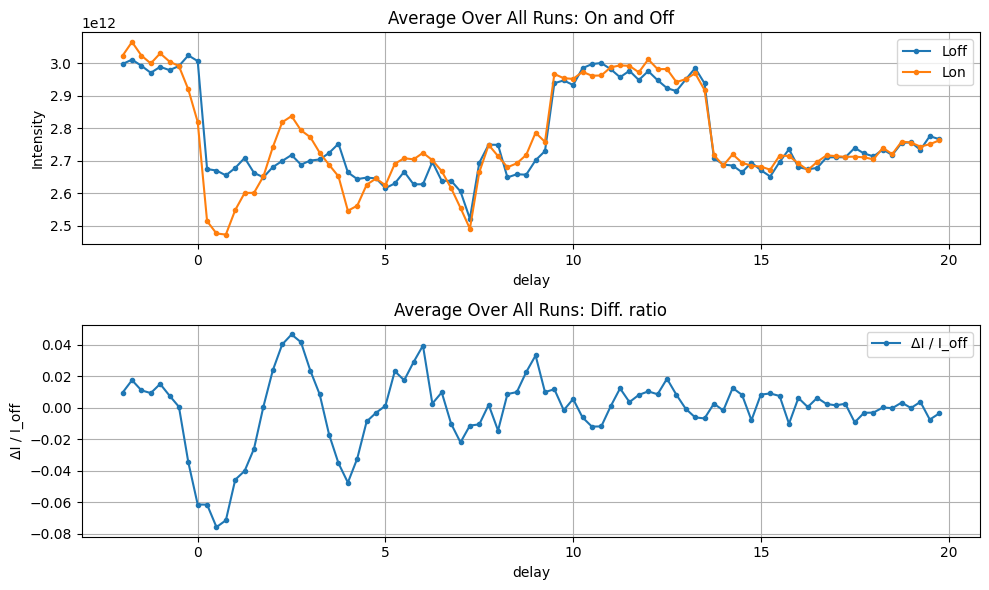

In [150]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Containers: group by delay (position)
pos_dict = defaultdict(list)
on_dict = defaultdict(list)
off_dict = defaultdict(list)
diff_dict = defaultdict(list)

# Gather data
for (run_n, scan_n), data in dataset_for_intensity.items():
    positions = data["positions"]
    on = data["signals_on"]
    off = data["signals_off"]
    diff = data["signals_diff"]
    
    for i, pos in enumerate(positions):
        pos_dict[pos].append(pos)
        on_dict[pos].append(on[i])
        off_dict[pos].append(off[i])
        diff_dict[pos].append(diff[i])

# Sort by delay time
sorted_positions = sorted(pos_dict.keys())
avg_on = [np.mean(on_dict[pos]) for pos in sorted_positions]
avg_off = [np.mean(off_dict[pos]) for pos in sorted_positions]
avg_diff = [np.mean(diff_dict[pos]) for pos in sorted_positions]

# Plot
plt.figure(21, figsize=(10, 6))

# On & Off
plt.subplot(2, 1, 1)
plt.title("Average Over All Runs: On and Off")
plt.plot(sorted_positions, avg_off, '.-', label='Loff')
plt.plot(sorted_positions, avg_on, '.-', label='Lon')
plt.grid()
plt.ylabel('Intensity')
plt.xlabel('delay')
plt.legend()

# Difference Ratio
plt.subplot(2, 1, 2)
plt.title("Average Over All Runs: Diff. ratio")
plt.plot(sorted_positions, avg_diff, '.-', label='ΔI / I_off')
plt.grid()
plt.ylabel('ΔI / I_off')
plt.xlabel('delay')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig('10_175K.png')

In [151]:
import pandas as pd

df_avg = pd.DataFrame({
    "delay": sorted_positions,
    "avg_diff_ratio": avg_diff
})

output_path = "306-312average_diff_ratio.csv"
df_avg.to_csv(output_path, index=False)
print(f"Saved averaged Diff. ratio to {output_path}")


Saved averaged Diff. ratio to 306-312average_diff_ratio.csv


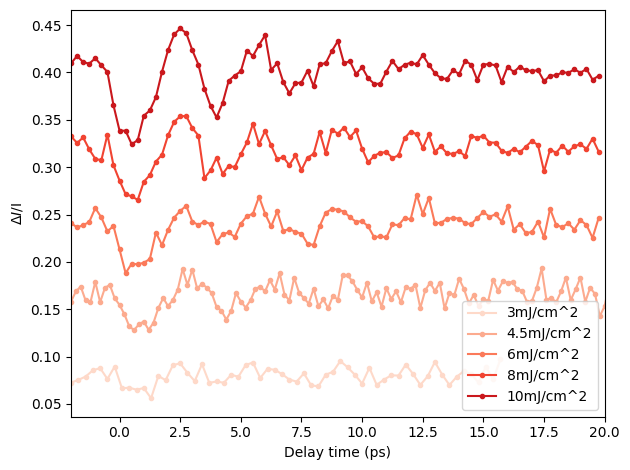

In [199]:
cmap = plt.get_cmap("Reds")

def load_plot(rg,lb,i):
    df = pd.read_csv(rg+"average_diff_ratio.csv")
    color=cmap(i*0.15)
    plt.plot(df["delay"], df["avg_diff_ratio"]+0.08*i,'.-', label=lb,color=color)
    return df

df_30=load_plot("277-291","3mJ/cm^2",1)
df_45=load_plot("204-216","4.5mJ/cm^2",2)
df_60=load_plot("267-276","6mJ/cm^2",3)
df_80=load_plot("298-304","8mJ/cm^2",4)
df_100=load_plot("306-312","10mJ/cm^2",5)

plt.xlim(-2,20)
plt.xlabel("Delay time (ps)")
plt.ylabel("$\Delta I$/I")

plt.legend()
plt.tight_layout()
plt.savefig('175K_stack.png')

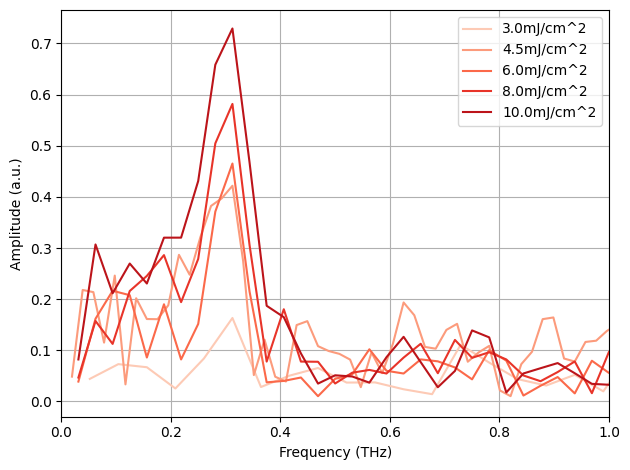

In [185]:
list = [30,45,60,80,100]
cmap = plt.get_cmap("Reds")
f_max=[]
a=0.2
for i in list:
    t = globals()[f"df_{i}"]["delay"].values
    y = globals()[f"df_{i}"]["avg_diff_ratio"].values
    # Mask for t >= 0
    mask = t >= 0
    t_fit = t[mask]
    y_fit_input = y[mask]
    # Fit polynomial (degree can be tuned)
    coeffs = np.polyfit(t_fit, y_fit_input, deg=2)
    background_fit = np.polyval(coeffs, t_fit)
    
    # Detrend only t >= 0
    y_detrended = y_fit_input - background_fit
    
    n_orig = len(y_detrended)
    n_pad =2**int(np.ceil(np.log2(n_orig)))
    
    # Pad the detrended signal with zeros
    y_padded = np.pad(y_detrended, (0, n_pad - n_orig), mode='constant')
    
    # Recalculate FFT with padded signal
    dt = np.mean(np.diff(t_fit))  # original sampling interval
    y_fft = fft(y_padded)
    freq = fftfreq(n_pad, d=dt)
    
    # Only positive frequencies
    mask = freq > 0
    freq_pos = freq[mask]
    fft_mag = np.abs(y_fft[mask])
    
    color = cmap(a)
    plt.plot(freq_pos, fft_mag,label=str(i*0.1)+'mJ/cm^2',color=color)
    a=a+0.15
    f_max.append(max(fft_mag))
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True)
plt.legend()
plt.xlim(0,1)
plt.tight_layout()
plt.savefig('175K_fluence.png')
plt.show()

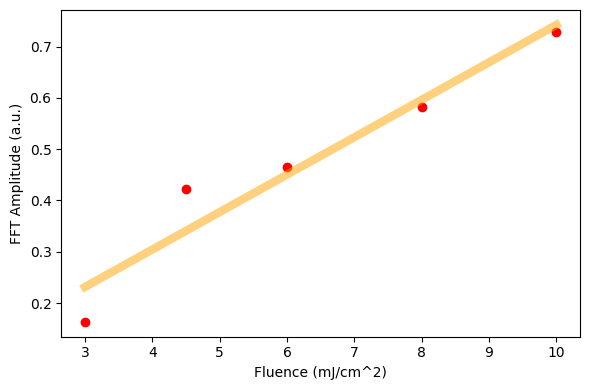

In [190]:
#plt.scatter(np.array(list)*0.1,f_max)
x= np.array(list)*0.1
y=f_max
# Linear fit: y = m*x + b
coefficients = np.polyfit(x,y, 1)
m, b = coefficients

# Create fit line
y_fit = m * x + b

# Plot
plt.figure(figsize=(6,4))
plt.scatter(x, y, label='Data', color='Red')
plt.plot(x, y_fit, linewidth=6,alpha=0.5,color='Orange')
plt.xlabel('Fluence (mJ/cm^2)')
plt.ylabel('FFT Amplitude (a.u.)')

plt.tight_layout()
plt.savefig('175K_fitting.png')
plt.show()

In [117]:
t = df_84["delay"].values
y = df_84["avg_diff_ratio"].values

In [118]:
# Mask for t >= 0
mask = t >= 0
t_fit = t[mask]
y_fit_input = y[mask]

In [121]:
# Fit polynomial (degree can be tuned)
coeffs = np.polyfit(t_fit, y_fit_input, deg=2)
background_fit = np.polyval(coeffs, t_fit)

# Detrend only t >= 0
y_detrended = y_fit_input - background_fit


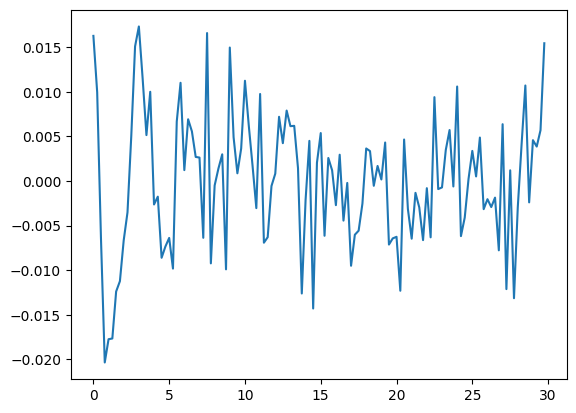

In [122]:
plt.plot(t_fit,y_detrended)

In [123]:
n_orig = len(y_detrended)
n_pad =2**int(np.ceil(np.log2(n_orig)))

# Pad the detrended signal with zeros
y_padded = np.pad(y_detrended, (0, n_pad - n_orig), mode='constant')


In [124]:
# Recalculate FFT with padded signal
dt = np.mean(np.diff(t_fit))  # original sampling interval
y_fft = fft(y_padded)
freq = fftfreq(n_pad, d=dt)

# Only positive frequencies
mask = freq > 0
freq_pos = freq[mask]
fft_mag = np.abs(y_fft[mask])

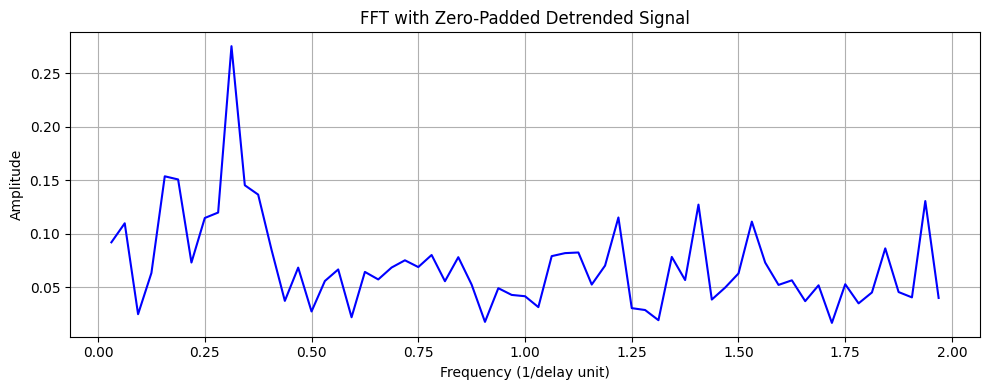

In [125]:
plt.figure(figsize=(10, 4))
plt.plot(freq_pos, fft_mag, 'b-')
plt.xlabel("Frequency (1/delay unit)")
plt.ylabel("Amplitude")
plt.title("FFT with Zero-Padded Detrended Signal")
plt.grid(True)
plt.tight_layout()
plt.show()

In [126]:
df_fft = pd.DataFrame({
    "frequency": freq_pos,
    "amplitude": fft_mag
})
df_fft.to_csv("84-98fft_result_padded.csv", index=False)
print("Saved FFT results to fft_result_padded.csv")


Saved FFT results to fft_result_padded.csv


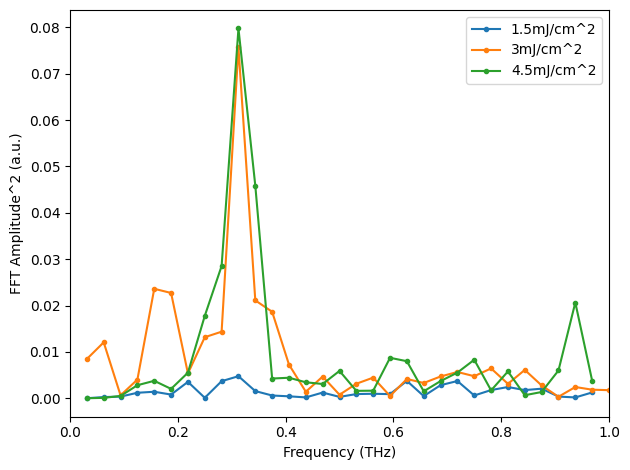

In [130]:
def load_plot(rg,lb,i):
    df = pd.read_csv(rg+"fft_result_padded.csv")
    plt.plot(df["frequency"], df["amplitude"]**2, '.-', label=lb)
    return df

df_100=load_plot("100-116","1.5mJ/cm^2",1)
df_84=load_plot("84-98","3mJ/cm^2",2)

df_117=load_plot("117-123","4.5mJ/cm^2",3)

plt.xlabel("Frequency (THz)")
plt.ylabel("FFT Amplitude^2 (a.u.)")
#plt.title("Averaged Diff. Ratio from File")
plt.xlim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig('200K_fluence.png')